In [343]:
import itk

from constants import *
import os

names = os.listdir(volumes_path)

output_dir="prepped_data"

import itkwidgets

import numpy as np
import matplotlib.pyplot as plt

debug=False



In [332]:
import pickle
def load_image_annotation(name):
    image = itk.imread(volumes_path + name)
    annotations = [
        np.argmax(pickle.load(
            open(
                annotations_path + name[:-5] + "axis" + str(i) + ".pickle",
                "rb"
            )
        )[:, :, 3], 0)
        for i in [0, 1]
    ]
    for i in range(2):
        annotations[i] = image.GetSpacing()[i] * annotations[i]
    return image, annotations


In [333]:
image, annotations = load_image_annotation(names[18])

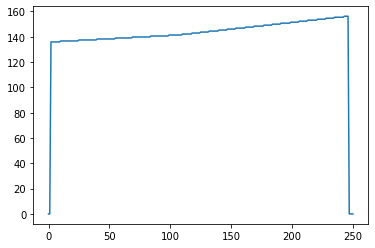

In [334]:
plt.plot(annotations[0])

In [325]:
class TwoSensorProbe:
    def __init__(self, side_offset, angle):
        self.side_offset = side_offset
        self.angle = angle
    
    def get_origin_direction(self, origin, direction, idx):
        """idx = 1 or -1"""
        origin = np.array(origin) +  idx * self.side_offset * direction[:, 2]
        angle = self.angle * idx
        direction = np.dot(direction, np.array([[1, 0, 0],
                                                [0, np.cos(angle), np.sin(angle)],
                                                [0, -np.sin(angle), np.cos(angle)]]))
        return origin, direction
    
def slice_multiprobe(image, probe, origin, direction):
    res = []
    for idx in [-1, 1]:
        o, d = probe.get_origin_direction(origin, direction, idx)
        if debug:
            pass#print(o, d)
        p = SliceParams(
            o, d,
            width=100,
            height=100)

        x = spine_slice(image, p)

        x = itk.GetArrayFromImage(x)
        x = x[0]
        res.append(x)

    return res
         

class SliceParams:
    def __init__(self, position, direction=np.identity(3), origin="center", width=100, height=100, px=128):
        self.position=position
        self.direction=direction
        self.origin=origin
        self.width=width
        self.height=height
        self.px=px
        
        assert len(self.position) == 3
        
def spine_slice(image, params):
    """
    image is the ITK image to slice from
    params is a SliceParams object"""
    output_spacing = [params.height / params.px, params.width / params.px, 1]
    
    
    output_origin = [
            val + params.direction[j, 0] * -params.height / 2 + params.direction[j, 1] * -params.width / 2
            for j, val in enumerate(params.position)
        ]

    return itk.resample_image_filter(
        image, 
        output_origin = output_origin,
        output_spacing = output_spacing, 
        OutputDirection=itk.matrix_from_array(np.ascontiguousarray(params.direction)), 
        size=[params.px, params.px, 1])
import matplotlib.pyplot as plt


def random_small_rotation(factor = 10):
    R = scipy.linalg.orth(np.random.randn(3, 3).astype(np.float64))
    lam, J = scipy.linalg.eig(R)
    RR = np.real(np.dot(np.dot(J, np.diag(lam)**(1 / factor)), np.linalg.inv(J)))
    return RR

def shitty_ultrasound(x):
    y = x[0, :, :]

    y = y + 1000
    y = abs(1 - y[:, 1:] / y[:, :-1])

    denominator = np.cumsum(y, axis=1) + .01
    return np.maximum(-10, np.log(np.abs(y / 4**denominator + .0001 * np.random.randn(128, 127)) ))

In [335]:
j = np.random.randint(80)
image, annotations = load_image_annotation(names[j])



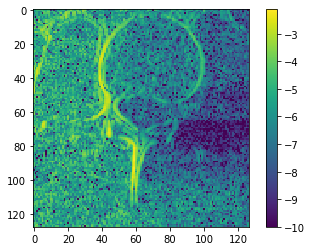

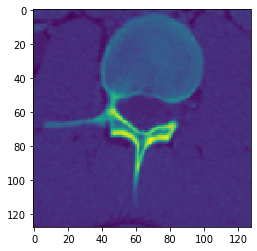

In [336]:
slice_idx = np.random.randint(230)
p = SliceParams(
    [annotations[1][slice_idx], -annotations[0][slice_idx], -slice_idx],
    random_small_rotation(factor=30),
    width=100,
    height=100)

x = spine_slice(image, p)

x = itk.GetArrayFromImage(x)


plt.imshow(shitty_ultrasound(x))
plt.colorbar()
plt.show()
plt.imshow(x[0, :, :])

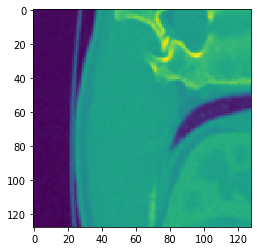

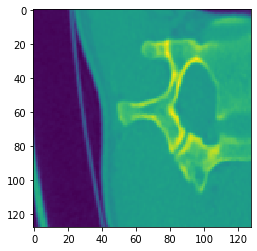

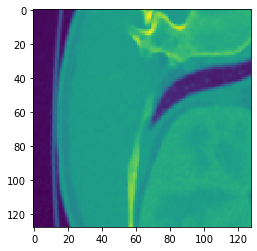

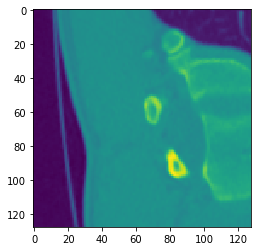

In [339]:
def generate_sample(image, annotations):
    slice_idx = np.random.randint(50, len(annotations[0]) - 50)

    direction = np.dot(random_small_rotation(), np.array([[0, 0, 1],
                  [-1, 0, 0],
                  [0, -1, 0]], dtype=np.float64))

    origin = np.array([annotations[1][slice_idx], -annotations[0][slice_idx], -slice_idx]) + np.random.randn(3) * 15

    probe = TwoSensorProbe(20, -np.pi /4)


    a, b = slice_multiprobe(image, probe, origin, direction)
    if debug:
        plt.imshow(a)
        plt.show()
        plt.imshow(b)
        plt.show()


    movement_relative_to_image_1 = np.random.randn(3) * 10
    rotation_relative_to_image_1 = random_small_rotation(factor=70)

    direction_2 = np.dot(direction, rotation_relative_to_image_1)
    origin_2 = origin + np.transpose(np.dot(direction, movement_relative_to_image_1.transpose()))

    c, d = slice_multiprobe(image, probe, origin_2, direction_2)
    if debug: 
        plt.imshow(c)
        plt.show()
        plt.imshow(d)
        plt.show()
        
    return {"data": [a, b, c, d], "classes": [movement_relative_to_image_1, rotation_relative_to_image_1]}
debug=True

generate_sample(image, annotations)

debug=False


In [344]:
for name in names:
    print(name)
    
    image, annotations = load_image_annotation(name)
    
    res = []
    
    for _ in range(2048):
        res.append(generate_sample(image, annotations))
    
    with open(output_dir + "/" + name[:-5] + "pregenerated.pickle", "wb") as f:
        pickle.dump(res, f)

Pancreas.nrrd
Pancreas_1.nrrd
Pancreas_10.nrrd
Pancreas_11.nrrd
Pancreas_12.nrrd
Pancreas_13.nrrd
Pancreas_14.nrrd
Pancreas_15.nrrd
Pancreas_16.nrrd
Pancreas_17.nrrd
Pancreas_18.nrrd
Pancreas_19.nrrd
Pancreas_2.nrrd
Pancreas_20.nrrd
Pancreas_21.nrrd
Pancreas_22.nrrd
Pancreas_23.nrrd
Pancreas_24.nrrd
Pancreas_25.nrrd
Pancreas_26.nrrd
Pancreas_27.nrrd
Pancreas_28.nrrd
Pancreas_29.nrrd
Pancreas_3.nrrd
Pancreas_30.nrrd
Pancreas_31.nrrd
Pancreas_32.nrrd
Pancreas_33.nrrd
Pancreas_34.nrrd
Pancreas_35.nrrd
Pancreas_36.nrrd
Pancreas_37.nrrd
Pancreas_38.nrrd
Pancreas_39.nrrd
Pancreas_4.nrrd
Pancreas_40.nrrd
Pancreas_41.nrrd
Pancreas_42.nrrd
Pancreas_43.nrrd
Pancreas_44.nrrd
Pancreas_45.nrrd
Pancreas_46.nrrd
Pancreas_47.nrrd
Pancreas_48.nrrd
Pancreas_49.nrrd
Pancreas_5.nrrd
Pancreas_50.nrrd
Pancreas_51.nrrd
Pancreas_52.nrrd
Pancreas_53.nrrd
Pancreas_54.nrrd
Pancreas_55.nrrd
Pancreas_56.nrrd
Pancreas_57.nrrd
Pancreas_58.nrrd
Pancreas_59.nrrd
Pancreas_6.nrrd
Pancreas_60.nrrd
Pancreas_61.nrrd
Pancre

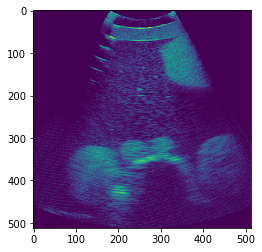

In [277]:
len(zz)


516

In [278]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [292]:
l = [abs(np.log(2.**n) / np.log(10) - round(np.log(2.**n) / np.log(10.))) for k, n in enumerate(range(100))]
np.array(l) < 

[0.0,
 0.30102999566398114,
 0.3979400086720377,
 0.09691001300805657,
 0.20411998265592457,
 0.4948500216800942,
 0.19382002601611314,
 0.10720996964786789,
 0.40823996531184914,
 0.2907300390241696,
 0.010299956639811647,
 0.3113299523037929,
 0.3876400520322263,
 0.08661005636824504,
 0.21441993929573577,
 0.484550065040283,
 0.18352006937630172,
 0.11750992628767953,
 0.4185399219516608,
 0.28043008238435796,
 0.020599913279623294,
 0.32162990894360455,
 0.3773400953924142,
 0.07631009972843295,
 0.22471989593554742,
 0.47425010840047044,
 0.17322011273649007,
 0.12780988292749207,
 0.42883987859147155,
 0.2701301257445454,
 0.030899869919434053,
 0.3319298655834171,
 0.36704013875260344,
 0.06601014308862041,
 0.23501985257535907,
 0.4639501517606579,
 0.16292015609667843,
 0.1381098395673046,
 0.4391398352312841,
 0.25983016910473467,
 0.04119982655924659,
 0.34222982222322784,
 0.3567401821127909,
 0.05571018644880965,
 0.2453198092151716,
 0.4536501951208489,
 0.152620199456865

In [289]:
2**93

9903520314283042199192993792